Minimum image and text conditional diffusion DDPM training / generation code for personal understaning.  

- data : text-image pair dataset `jackyhate/text-to-image-2M` (only 50k samples used)  
- model : simple conditional Unet with time embedding  
- text encoder : pretrained light weight encoder `sentence-transformers/all-MiniLM-L6-v2` (freezed)  
- no latent encoder such as VAE (i.e., non latent diffusion)  
- timestep conditionong : applys shift and scale modulate by timesteps to iamge and conditioning image stacked image  
- conditioning image conditioning : simply stack input image and conditioning image along channels  
- text conditioning : fuse image latents with text embedding using cross attention at each Unet layers  


In [1]:
!pip install -q -U datasets einops transformers


[notice] A new release of pip is available: 23.1.2 -> 25.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
from typing import Tuple, Any, List, Dict
import math

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image

In [18]:
# Data Config
IMG_SHAPE = (3, 224, 224)

TEXT_PADDING_MAX_LENGTH = 150
TEXT_EMB_DIM = 384

# Training Config
EPOCHS = 15
TRAIN_BATCH_SIZE = 32
LR = 3e-4
WEIGHT_DECAY = 1e-2

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32#torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

In [4]:
device, dtype

(device(type='cuda'), torch.float32)

## 1. Load Pretrained Text Encoder

In [5]:
# text_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').eval()
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
text_encoder = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device).eval()
text_encoder._requires_grad = False

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

## 2. Data Pereparation

In [6]:
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files="data_512_2M/data_000000.tar", cache_dir='.')['train']

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

data_000000.tar:   0%|          | 0.00/7.48G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
hf_dataset

Dataset({
    features: ['__key__', '__url__', 'jpg', 'json'],
    num_rows: 50000
})

In [8]:
hf_dataset[0]['jpg'].size, hf_dataset[0]['json']

((512, 512),
 {'prompt': 'A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.'})

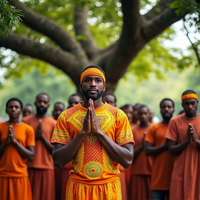

In [9]:
hf_dataset[0]['jpg'].resize((200, 200))

In [16]:
sr_token_counts = pd.Series(hf_dataset['json']).map(lambda x: len(tokenizer(x['prompt'], return_tensors='pt')['input_ids'][0]))

<Axes: ylabel='Frequency'>

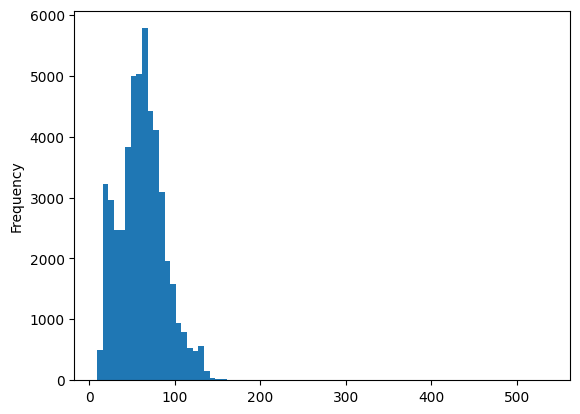

In [17]:
sr_token_counts.plot.hist(bins=80)

In [19]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMG_SHAPE[1:], interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMG_SHAPE[1:]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

In [20]:
@torch.inference_mode()
def encode_text(texts):
    inputs = tokenizer(texts, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    text_encoder_output = text_encoder(**inputs)
    text_emb = text_encoder_output['last_hidden_state']
    return inputs['attention_mask'].bool(), text_emb

def preprocess_data(examples):
    images = [image.convert("RGB") for image in examples['jpg']]
    images = [image_transforms(image) for image in images]

    examples["pixel_values"] = images
    text_attn_mask, text_emb = encode_text([d['prompt'] for d in examples['json']])
    examples["text_emb"] = text_emb
    examples["text_attn_mask"] = text_attn_mask

    return examples

In [21]:
%%time
hf_dataset = hf_dataset.with_transform(preprocess_data)

CPU times: user 1.17 s, sys: 211 ms, total: 1.38 s
Wall time: 1.55 s


In [22]:
hf_dataset[0].keys()

dict_keys(['__key__', '__url__', 'jpg', 'json', 'pixel_values', 'text_emb', 'text_attn_mask'])

In [23]:
hf_dataset[0]['pixel_values'].shape, hf_dataset[0]['text_emb'].shape, hf_dataset[0]['text_attn_mask'].shape

(torch.Size([3, 224, 224]), torch.Size([150, 384]), torch.Size([150]))

In [24]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    text_emb = torch.stack([example["text_emb"] for example in examples])
    text_attn_mask = torch.stack([example["text_attn_mask"] for example in examples])

    return {
        "pixel_values": pixel_values.to(dtype),
        "text_emb": text_emb.to(dtype),
        'text_attn_mask': text_attn_mask,
    }

In [25]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)

In [29]:
_batch = next(iter(train_dataloader))

In [30]:
{k: v.shape for k, v in _batch.items()}

{'pixel_values': torch.Size([32, 3, 224, 224]),
 'text_emb': torch.Size([32, 100, 384]),
 'text_attn_mask': torch.Size([32, 100])}

## 3. Model

In [26]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

In [ ]:
TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().shape

torch.Size([1000, 784])

In [27]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

def positionalencoding1d(d_model, length, dtype=dtype):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(dtype)

In [28]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, ch_scale = 1, c_emb_dim = TEXT_EMB_DIM):
        super(ConditionalUNet, self).__init__()

        # エンコーダ部分
        self.enc1 = self.conv_block(in_channels, 64 // ch_scale)
        self.enc1_c_in_proj = nn.Linear(c_emb_dim, self.enc1[0].out_channels)
        self.enc2 = self.conv_block(64 // ch_scale, 128 // ch_scale)
        self.enc2_c_in_proj = nn.Linear(c_emb_dim, self.enc2[0].out_channels)
        self.enc3 = self.conv_block(128 // ch_scale, 256 // ch_scale)
        self.enc3_c_in_proj = nn.Linear(c_emb_dim, self.enc3[0].out_channels)
        self.enc4 = self.conv_block(256 // ch_scale, 512 // ch_scale)
        self.enc4_c_in_proj = nn.Linear(c_emb_dim, self.enc4[0].out_channels)

        # ボトム部分
        self.center = self.conv_block(512 // ch_scale, 1024 // ch_scale)
        self.center_c_in_proj = nn.Linear(c_emb_dim, self.center[0].out_channels)

        # デコーダ部分
        self.upconv4 = self.upconv_block(1024 // ch_scale, 512 // ch_scale)
        self.upconv4_c_in_proj = nn.Linear(c_emb_dim, self.upconv4[0].out_channels)
        self.upconv3 = self.upconv_block(512 // ch_scale, 256 // ch_scale)
        self.upconv3_c_in_proj = nn.Linear(c_emb_dim, self.upconv3[0].out_channels)
        self.upconv2 = self.upconv_block(256 // ch_scale, 128 // ch_scale)
        self.upconv2_c_in_proj = nn.Linear(c_emb_dim, self.upconv2[0].out_channels)
        self.upconv1 = self.upconv_block(128 // ch_scale, 64 // ch_scale)
        self.upconv1_c_in_proj = nn.Linear(c_emb_dim, self.upconv1[0].out_channels)

        # 出力層
        self.final_conv = nn.Conv2d(64 // ch_scale, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def upconv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x, c, c_mask = None):
        """
        x: image tensor of shape (bs, ch, h, w)
        c: conditional embeddings of shape (bs, seq_len_c, emb_dim)
        c_mask: attention mask for c of shape (bs, seq_len_c)
        """
        # エンコーダ
        enc1 = self.enc1(x)
        # enc1_c_fused = self._fuse_x_and_cond(enc1, self.enc1_c_in_proj(c), c_mask)
        enc1_c_fused = enc1
        enc2 = self.enc2(F.max_pool2d(enc1_c_fused, 2))
        enc2_c_fused = self._fuse_x_and_cond(enc2, self.enc2_c_in_proj(c), c_mask)
        enc3 = self.enc3(F.max_pool2d(enc2_c_fused, 2))
        enc3_c_fused = self._fuse_x_and_cond(enc3, self.enc3_c_in_proj(c), c_mask)
        enc4 = self.enc4(F.max_pool2d(enc3_c_fused, 2))
        enc4_c_fused = self._fuse_x_and_cond(enc4, self.enc4_c_in_proj(c), c_mask)

        # ボトム部分
        center = self.center(F.max_pool2d(enc4_c_fused, 2))
        center_c_fused = self._fuse_x_and_cond(center, self.center_c_in_proj(c), c_mask)

        # デコーダ
        up4 = self.upconv4(center_c_fused)
        up4_c_fused = self._fuse_x_and_cond(up4, self.upconv4_c_in_proj(c), c_mask)
        up3 = self.upconv3(up4_c_fused + enc4_c_fused)  # skip connection
        up3_c_fused = self._fuse_x_and_cond(up3, self.upconv3_c_in_proj(c), c_mask)
        up2 = self.upconv2(up3_c_fused + enc3_c_fused)  # skip connection
        up2_c_fused = self._fuse_x_and_cond(up2, self.upconv2_c_in_proj(c), c_mask)
        up1 = self.upconv1(up2_c_fused + enc2_c_fused)  # skip connection
        # up1_c_fused = self._fuse_x_and_cond(up1, self.upconv1_c_in_proj(c), c_mask)
        up1_c_fused = up1

        # 最終出力
        output = self.final_conv(up1_c_fused + enc1_c_fused)  # skip connection
        return output

    def _fuse_x_and_cond(self, x, c, c_mask):
        x_patched = self._patchfy(x)  # (bs, ch, h, w) => (bs, x_seq_len, ch)
        x_seqlen = x_patched.shape[1]
        mask = c_mask.unsqueeze(1).repeat((1, x_seqlen,1)) if c_mask is not None else None  # (bs, seq_len_c) => (bs, seq_len_xpacth, seq_len_c)
        x_c_fused = F.scaled_dot_product_attention(
            query=x_patched, key=c, value=c,
            attn_mask=mask,
            dropout_p=0.05,
            is_causal=False
        )
        x_c_fused = self._unpatchify(x_c_fused)  # (bs, x_seq_len, ch) => (bs, ch, h, w)
        assert x.shape == x_c_fused.shape
        return x + x_c_fused

    def _patchfy(self, x):
        """convert image (bs, ch, h, w) to sequential format (bs, h x w, ch)
        x: image tensor of shape (bs, ch, h, w)
        """
        bs, ch, h, w = x.shape
        return einops.rearrange(x, 'b c h w -> b (h w) c')

    def _unpatchify(self, x):
        """convert sequential image (bs, h x w, ch) to (bs, ch, h, w)
        x: image tensor of shape (bs, h x w, ch)
        """
        bs, hxw, ch = x.shape
        h = w = int(hxw**0.5)
        return einops.rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

In [34]:
class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        img_shape: Tuple[int, int, int] = IMG_SHAPE,  # (ch, h, w)
        time_emb_dim: int = 512,
    ):
        super().__init__()
        self._img_shape = img_shape
        self._unet_denoiser = ConditionalUNet()
        self._timestep_embedder = TimestepEmbedder(hidden_size=time_emb_dim)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(time_emb_dim, 2 * (IMG_SHAPE[0] * 32 * 32), bias=True),
        )
        self._c_pos_emb = positionalencoding1d(TEXT_EMB_DIM, TEXT_PADDING_MAX_LENGTH)

    def forward(self, x: torch.Tensor, t: torch.Tensor, c, c_mask = None):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, ch, h, w)
            t (torch.Tensor): time steps with shape (bs,)
            c (torch.Tensor): conditional embeddings with shape (bs, seq_len_c, emb_dim)
            c_mask (torch.Tensor): attention mask for c with shape (bs, seq_len_c)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        bs, ch, h , w = x.shape
        assert self._img_shape == (ch, h, w)
        t_emb = self._timestep_embedder(t)  # (bs,) => (bs, time_emb_dim)
        shift, scale = self._adaLN_modulation(t_emb).chunk(2, dim=1)
        shift = F.interpolate(shift.reshape((bs, ch, 32, 32)), size=(h, w), mode='bilinear').reshape(*x.shape)  # (bs, ch x h x w) => (bs, ch, h, w)
        scale = F.interpolate(scale.reshape((bs, ch, 32, 32)), size=(h, w), mode='bilinear').reshape(*x.shape)  # (bs, ch x h x w) => (bs, ch, h, w)
        x_t_fused = modulate(x, shift, scale)  # make x+cond_image conditioned on timesteps
        c = c + self._c_pos_emb.to(c.device)
        added_noise = x - self._unet_denoiser(x_t_fused, c=c, c_mask=c_mask)
        return added_noise

In [35]:
_denoise_model = DenoiseModel().to(device).to(dtype).eval()
torch.save(_denoise_model.state_dict(), 'denoise_model.pth')
!ls -lh ./denoise_model.pth
!rm ./denoise_model.pth

-rw-r--r-- 1 root root 101M Jan 29 09:06 ./denoise_model.pth


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
{name: param.numel() for name, param in _denoise_model.named_parameters() if param.requires_grad}

{'_unet_denoiser.enc1.0.weight': 1728,
 '_unet_denoiser.enc1.0.bias': 64,
 '_unet_denoiser.enc1.2.weight': 36864,
 '_unet_denoiser.enc1.2.bias': 64,
 '_unet_denoiser.enc1_c_in_proj.weight': 24576,
 '_unet_denoiser.enc1_c_in_proj.bias': 64,
 '_unet_denoiser.enc2.0.weight': 73728,
 '_unet_denoiser.enc2.0.bias': 128,
 '_unet_denoiser.enc2.2.weight': 147456,
 '_unet_denoiser.enc2.2.bias': 128,
 '_unet_denoiser.enc2_c_in_proj.weight': 49152,
 '_unet_denoiser.enc2_c_in_proj.bias': 128,
 '_unet_denoiser.enc3.0.weight': 294912,
 '_unet_denoiser.enc3.0.bias': 256,
 '_unet_denoiser.enc3.2.weight': 589824,
 '_unet_denoiser.enc3.2.bias': 256,
 '_unet_denoiser.enc3_c_in_proj.weight': 98304,
 '_unet_denoiser.enc3_c_in_proj.bias': 256,
 '_unet_denoiser.enc4.0.weight': 1179648,
 '_unet_denoiser.enc4.0.bias': 512,
 '_unet_denoiser.enc4.2.weight': 2359296,
 '_unet_denoiser.enc4.2.bias': 512,
 '_unet_denoiser.enc4_c_in_proj.weight': 196608,
 '_unet_denoiser.enc4_c_in_proj.bias': 512,
 '_unet_denoiser.cen

In [37]:
with torch.inference_mode():
    _out = _denoise_model(
        torch.randn(1, 3, *IMG_SHAPE[-2:]).to(device).to(dtype),
        torch.tensor([0.0]).to(device).to(dtype),
        c=torch.randn(1, TEXT_PADDING_MAX_LENGTH, TEXT_EMB_DIM).to(device).to(dtype),
        c_mask=torch.ones(1, TEXT_PADDING_MAX_LENGTH).to(device),
    )
    print(_out.shape)

torch.Size([1, 3, 224, 224])


## 4. DDPM Scheduler Utils

In [38]:
def get_alpha_beta_sigma_scheduler(
    steps: int,
    # noise_beta = (0.5, 1.0),
    noise_beta = (0.0001, 0.02),
    device = device,
    dtype = dtype,
) -> Tuple[torch.Tensor, torch.Tensor]:
    b1, b2 = noise_beta
    beta_scheduler = [b1 + i*(b2-b1)/steps for i in range(steps)]
    alpha_scheduler = [1.0 - beta for beta in beta_scheduler]
    beta_scheduler = torch.tensor(beta_scheduler, device=device, dtype=torch.float32)
    alpha_scheduler = torch.tensor(alpha_scheduler, device=device, dtype=torch.float32)
    alpha_cumprod_scheduler = alpha_scheduler.cumprod(0)
    sigma_scheduler = (beta_scheduler * (1.0 - alpha_cumprod_scheduler.roll(1)) / (1.0 - alpha_cumprod_scheduler)).sqrt()
    sigma_scheduler[0] = 0.0
    return beta_scheduler.to(device), alpha_scheduler.to(device), alpha_cumprod_scheduler.to(device), sigma_scheduler.to(device)

In [39]:
beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler = get_alpha_beta_sigma_scheduler(steps=STEPS, noise_beta=(0.0001, 0.02))

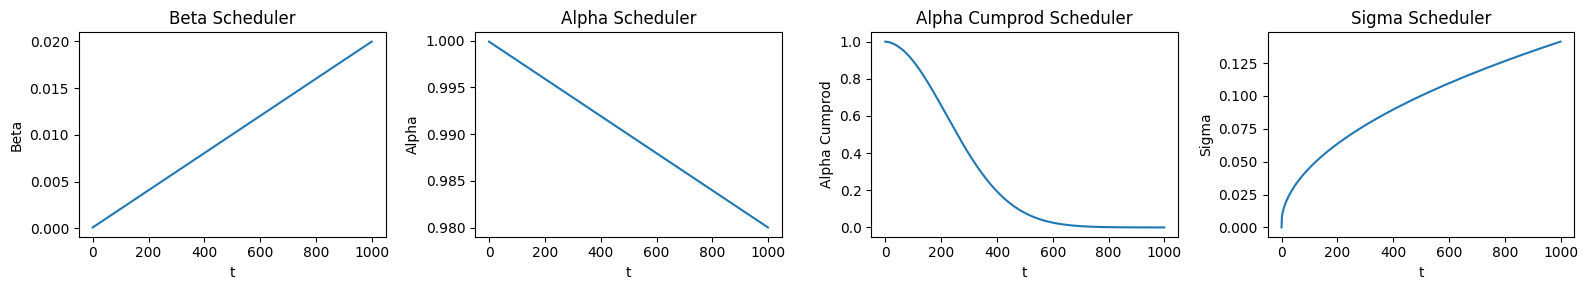

In [40]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*4, 3))

axes[0].plot(beta_scheduler.cpu().float().numpy())
axes[0].set_xlabel('t')
axes[0].set_ylabel('Beta')
axes[0].set_title('Beta Scheduler')

axes[1].plot(alpha_scheduler.cpu().float().numpy())
axes[1].set_xlabel('t')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha Scheduler')

axes[2].plot(alpha_cumprod_scheduler.cpu().float().numpy())
axes[2].set_xlabel('t')
axes[2].set_ylabel('Alpha Cumprod')
axes[2].set_title('Alpha Cumprod Scheduler')

axes[3].plot(sigma_scheduler.cpu().float().numpy())
axes[3].set_xlabel('t')
axes[3].set_ylabel('Sigma')
axes[3].set_title('Sigma Scheduler')

fig.tight_layout()

## 5. Denoise(generation) / Add Noise Utils

- Denoise (For Generation)

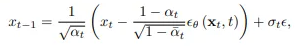

Following above equations, apply denoising process step by step to generate final image $x_0$ starting from pure noise $x_{t_{max}} \sim \mathcal{N}(0,\,1)$, where  
$\alpha_t=1-\beta_t$  
$\overline{\alpha}_{t} = \prod \alpha_t = \prod (1-\beta_t)$  
$ \sigma_{t}^2 = \frac{1.0 - \overline{\alpha}_{t-1}}{1.0 - \overline{\alpha}_{t}}\beta_t$  
$\epsilon_{\theta}(\boldsymbol{x}_{t}, t)$ : model output (predicted noise added to $x_t$)  
$\epsilon \sim \mathcal{N}(0,\,1)$


In [41]:
@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    texts: List[str],
    img_shape: Tuple[int, int, int] = IMG_SHAPE,
    steps: int = STEPS,
    beta_scheduler: torch.Tensor = beta_scheduler,
    alpha_scheduler: torch.Tensor = alpha_scheduler,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    debug: bool = False,
    device = device,
    return_only_final_image: bool = True,
    dtype = dtype,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    text_attn_mask, text_emb = encode_text(texts)
    bs = len(texts)
    x_t = init_noise = torch.randn(bs, *img_shape).to(device).to(dtype)
    x_t_list = [x_t] if not return_only_final_image else None

    for t in reversed(range(1, steps)):
        # predict noise to denoise from x_t
        pred_noise = denoise_model(
            x_t,
            torch.tensor([t]).repeat((bs,)).to(device).to(dtype),
            c=text_emb.to(device).to(dtype),
            c_mask=text_attn_mask.to(device),
        )
        if debug:
            print('pred', (pred_noise.min(), pred_noise.max()), (x_t.min(), x_t.max()))
        # apply denoise equation above
        x_prev_t = x_t - pred_noise * (1 - alpha_scheduler[t]) / ((1 - alpha_cumprod_scheduler[t]).sqrt())
        x_prev_t /= alpha_scheduler[t].sqrt()
        x_prev_t += sigma_scheduler[t] * torch.randn_like(x_prev_t)
        x_t = x_prev_t
        if debug:
            print(x_prev_t.max())
        if not return_only_final_image:
            x_t_list.append(x_t)

    if return_only_final_image:
        x_0 = x_t  # generated image x_0  (n_generate, ch, h, w)
    else:
        x_0 = torch.stack(x_t_list, dim=0)  # (steps, n_generate, ch, h, w)
    return x_0

In [42]:
gen_img = generate(_denoise_model, texts=[hf_dataset[0]['json']['prompt']])
print(gen_img.shape)

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830303..2.4224937].


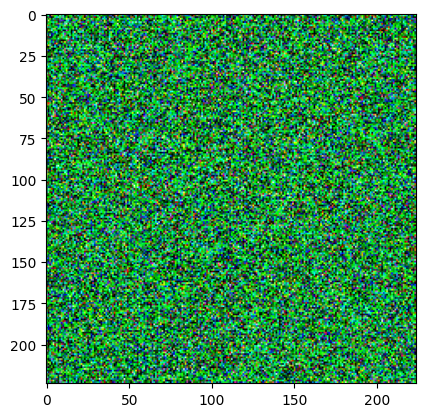

In [43]:
plt.imshow(gen_img[0].cpu().permute(1, 2, 0).float())

- Add Noise (For Training)

image.png

In [44]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    dtype = dtype,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, ch, h, w = x_0.shape
    random_timesteps = torch.randint(0, steps, (bs,)).to(x_0.device)
    alpha_prod = alpha_cumprod_scheduler[random_timesteps].reshape((bs, 1, 1, 1))

    noise = torch.randn_like(x_0)#.to(dtype)
    x_noisy = x_0 * alpha_prod.sqrt() + noise * (1 - alpha_prod).sqrt()
    return x_noisy, noise, random_timesteps

In [45]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))['pixel_values'].to(device).to(dtype))
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) torch.Size([32])


## 6. Run Training

In [46]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [47]:
model = DenoiseModel().to(device).to(dtype)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

epoch 0 : loss 0.04207760468125343
['A sepia-toned image of an old train station platform with a series of wooden pillars supporting a roof. The platform is empty, and there is a train track running parallel to the platform. The image has a vintage feel, with a watermark in the bottom left corner.', 'A large, cylindrical object with a metallic exterior and a series of concentric circles on its surface is suspended from the ceiling by a metal rod. The object is housed within a room with blue walls and a large window on the right side, allowing natural light to illuminate the space. Two individuals wearing white lab coats and face masks are present in the room, one standing closer to the left side and the other near the right side. The room appears to be a laboratory or a facility for the handling of the cylindrical object.', 'A composite image featuring a person with a red and yellow sash and a red and yellow scarf, with a red and yellow patterned background. The person is pointing upwa

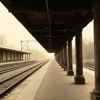

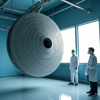

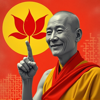

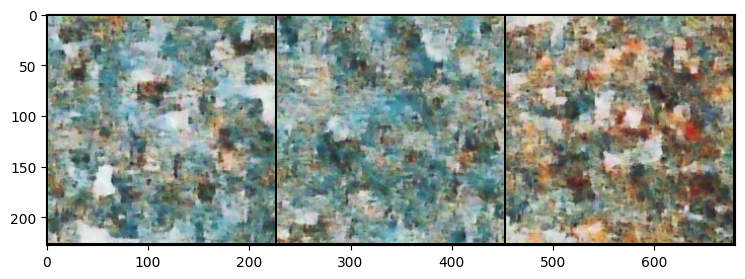

epoch 1 : loss 0.02710900641977787
['A woman is wearing a blue and white patterned blouse with a V-neckline and short sleeves, paired with blue jeans.', 'A large, brown, textured egg-like object with a pointed top and a smooth surface is resting on a red surface. The object is surrounded by greenery, with leaves and branches visible in the background. There are also some small, brown, nut-like objects scattered around the base of the egg.', "A scenic view of a coastal town with a clear blue sky and fluffy white clouds. The sun is shining brightly, and the sea is calm. The town is built on a hillside with red-tiled roofs and white buildings. A large house with a prominent chimney is visible in the foreground. The sky is adorned with a circular logo featuring the number '7' and the word 'REALTY'."]


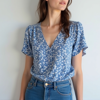

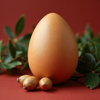

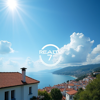

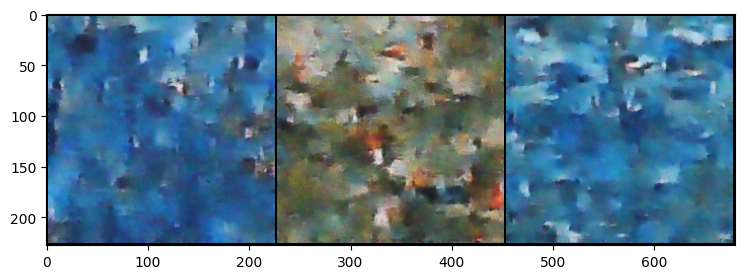

epoch 2 : loss 0.023442288860678673
['The first image shows a close-up of a water droplet falling into a body of water, creating a ripple effect. The droplet is in the center of the image, and the ripples are concentric circles that spread outwards. The water has a reflective quality, and there are no visible objects or creatures in the water.', 'A group of orange monkeys is perched on a tree branch surrounded by green leaves.', "The second image is a modified version of the first, where the woman's face and the background have been transformed into a cosmic scene. The woman's face now has a pinkish hue, and the background is filled with stars and nebulae, giving the impression of being in outer space. The text 'Truth in Aspect Astrology' remains at the top, and the woman's name 'Jewel' is still present at the bottom."]


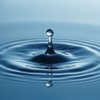

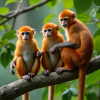

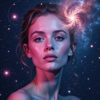

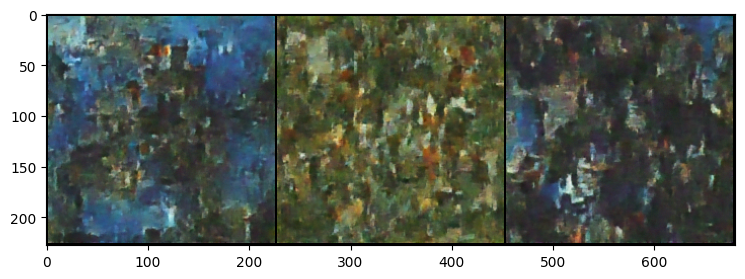

epoch 3 : loss 0.021190496161580086
['A sleek black luxury sedan is parked in front of a modern glass building with a red brick facade. The car has a shiny finish and is positioned on a paved surface. The building has large windows and a reflective glass surface, and there are trees and a clear sky in the background.', 'A blue plastic bucket with a smooth surface and a flat bottom. The bucket has a straight, vertical wall and a flat top. It is placed against a white background.', "A silver cufflink with a detailed design of a car's gearshift and the numbers '1', '2', '3', '4', 'R', and 'R' engraved on it. The cufflink is placed on a white background."]


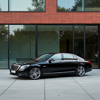

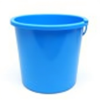

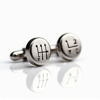

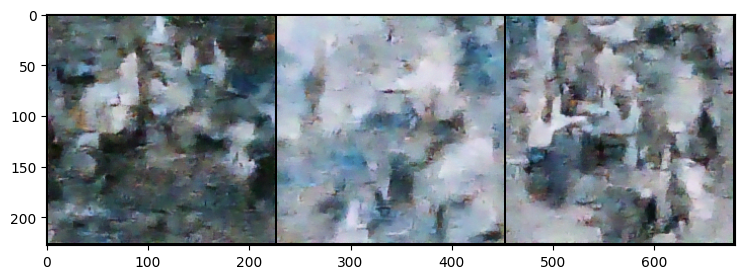

epoch 4 : loss 0.020207708701491356
['A sleek, modern stainless steel oven with a black glass door and a digital control panel. The oven has a flat, smooth surface with two knobs on the top left corner and a digital display in the center. The interior is empty, showing the dark interior of the oven.', 'An aerial view of a densely populated urban area with numerous buildings, roads, and vehicles. The image has a vintage, sepia-toned appearance, giving it an old-fashioned feel. The buildings are a mix of residential and commercial structures, with some showing signs of wear and age. The roads are busy with cars and trucks, and the overall scene conveys a bustling, lived-in environment.', 'A newborn baby is sleeping in a white and green baby blanket with a brown onesie.']


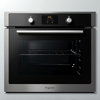

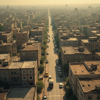

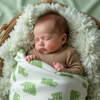

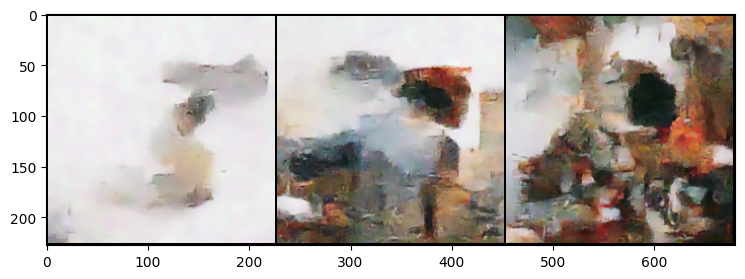

epoch 5 : loss 0.018917549401521683
['A monochrome image of an ancient temple with a cloudy sky above. The temple is surrounded by trees, and the ground is covered with grass and a dirt path leading to the temple. The image has a vintage feel due to the black and white color scheme.', 'A man with short hair is wearing a dark blue coat and a black scarf. He is smiling and looking directly at the camera. Behind him, there is a person holding a camera, and another person is partially visible on the left side of the image.', "A white background with a large black and red Chinese character on the left side, and a smaller version of the same character on the right side. Below the characters, there is a red and white text that reads 'DA PENG' on the left and 'SOU QIENG' on the right."]


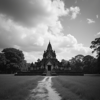

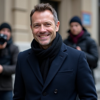

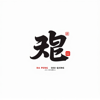

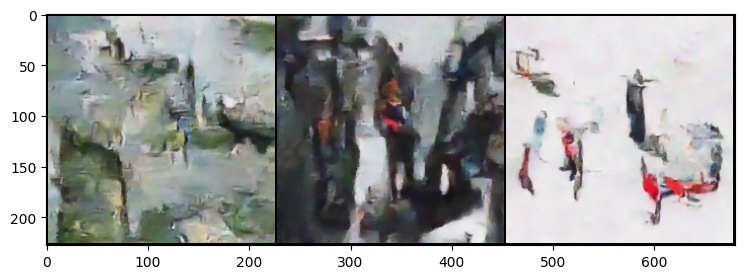

epoch 6 : loss 0.017852356657385826
['A red and white baseball jersey with a black silhouette of a person wearing a t-shirt on the front. The jersey has long sleeves and is worn over a white shirt.', 'A black and white striped carpet is laid out on the floor of a van, with a white cushion on top of it. The van is covered in plastic sheets, and there are various tools and a small yellow object on the floor.', 'A close-up image of coffee beans and coffee beans with a white bean-like substance. The coffee beans are in various shades of brown, and the white beans are light beige. The beans are arranged in a way that creates a gradient effect, with the coffee beans on the left and the white beans on the right.']


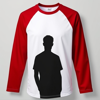

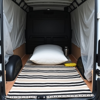

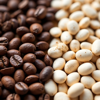

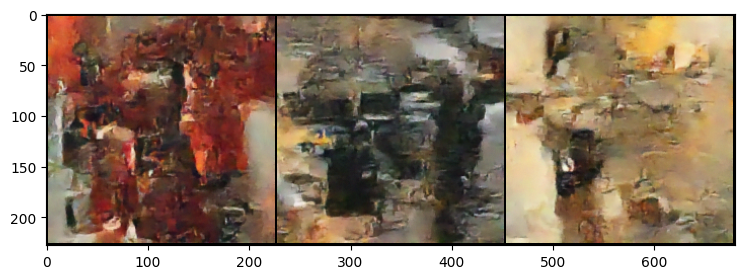

epoch 7 : loss 0.017313111573457718
["A skateboard with a colorful and intricate design is leaning against a wooden cabinet. The design features various elements such as skulls, snakes, and abstract patterns. The skateboard has a red deck with a white 'EBAY' logo in the center.", "The first image shows a wedding ceremony taking place under a large tent with a red and gold color scheme. The tent is adorned with hanging lanterns and a floral archway. A man in a blue shirt is standing near the entrance of the tent, and there are several guests in the background. The image is overlaid with a yellow banner that reads 'WEDDING CANCELLED' and a blue banner with the text '150 TABLES OF FOOD SOLD'.", "A red book cover with white text titled 'Ben-Hur II' and a subtitle '\\xe2\\x80\\xa6and the Book of Q' below it. The author's name, J. Paul Briggs, is at the bottom of the cover."]


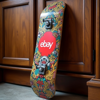

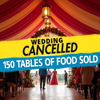

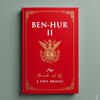

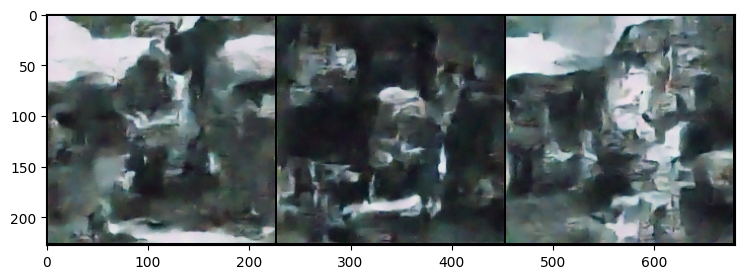

epoch 8 : loss 0.016982436180114746
['A pair of brown cowboy boots with intricate designs on the toes and heels, standing upright with the heels visible.', 'A man and a woman are standing on a beach holding a large fish. The man is wearing a yellow and green jacket, a hat, and blue shorts, while the woman is wearing a blue jacket, a hat, and beige pants. They are both smiling and looking at the fish. The sky is overcast, and the ocean is visible in the background.', 'A closed laptop with a purple cover and a black HP logo in the center.']


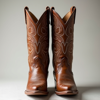

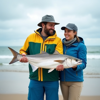

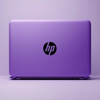

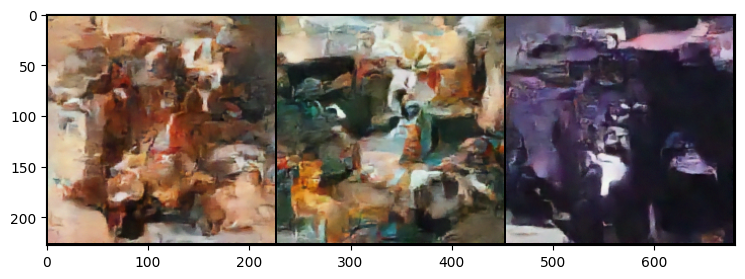

epoch 9 : loss 0.01636621356010437
['A sleek modern black office desk with a flat top and a set of drawers, accompanied by matching black cabinets and a black filing cabinet.', 'A modern blender with a sleek design and a digital display on the front. The blender has a black base with a metallic finish and a black lid with a clear plastic window. The blender is set against a white background.', "A dusty collector's item for a craftsman radial arm saw is displayed in a wooden case. The saw is mounted on a wooden stand, and various tools and hardware are scattered around the case."]


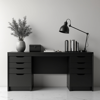

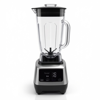

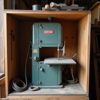

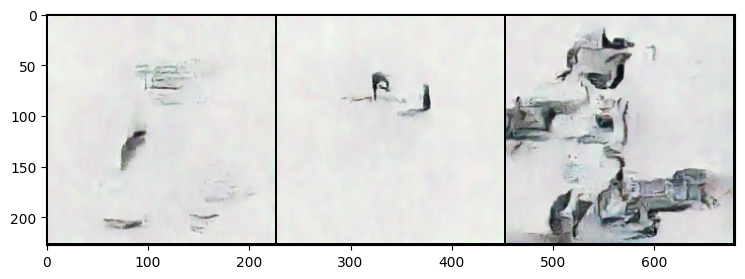

epoch 10 : loss 0.01632753573358059
["A close-up of a large, shiny pink balloon with a 'Happy 21st Birthday' message written in gold. The balloon is tied to a string and is surrounded by smaller balloons in various colors, including pink, red, and yellow. The background is blurred, with hints of a brick wall and a window.", 'The first image shows a cozy attic bedroom with a sloped ceiling and floral wallpaper. There are two twin beds with white bedding and green pillows. A white bench is placed at the foot of each bed. The room has a striped area rug on the wooden floor, and there are two white armchairs with green cushions. A chandelier hangs from the ceiling, and there are two wall-mounted lamps on either side of a window. The window has a view of a garden with a bench and a small table.', 'A close-up view of a black rectangular dish filled with a salad and two pieces of grilled chicken. The dish is placed on a dark surface with a fork and knife resting on a folded cloth napkin to th

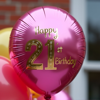

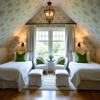

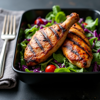

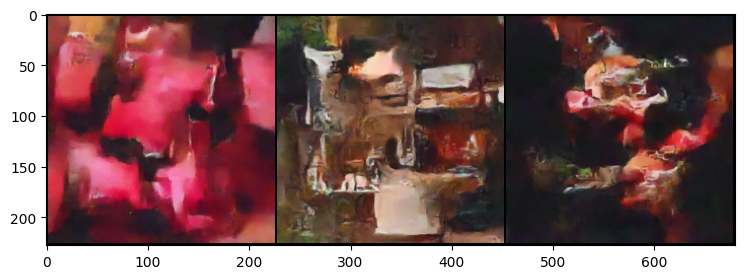

epoch 11 : loss 0.016224423423409462
["A black smartphone with a blue screen displaying various icons and a person's silhouette is lying on a white surface.", "A circular logo with a black border featuring the text 'WATCH OUT FOR FORKLIFT TRAFFIC' in white. The logo includes a stylized illustration of a forklift with a black body and yellow wheels, positioned in the center of the circle. The background is white.", 'A red race car with the number 23 on the side is parked on the track, surrounded by a crowd of spectators in the stands and on the sidelines. The stands are filled with people, some wearing orange vests, and there are multiple traffic lights and a Pepsi sign visible in the background.']


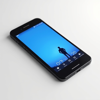

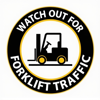

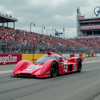

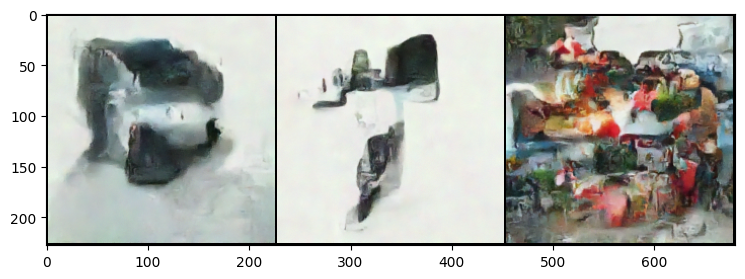

epoch 12 : loss 0.015220792964100838
['A golden brass kitchen faucet with a curved spout and two handles, one for hot water and one for cold water, is displayed against a white background.', 'A bottle of Sea Salt Spray by Oribe, featuring a dark brown label with a white logo and text, and a clear cap. The bottle is filled with a dark liquid and has a blue label at the bottom.', 'A silver towel rack with a green towel hanging on it, against a white wall.']


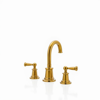

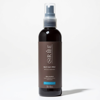

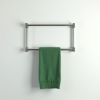

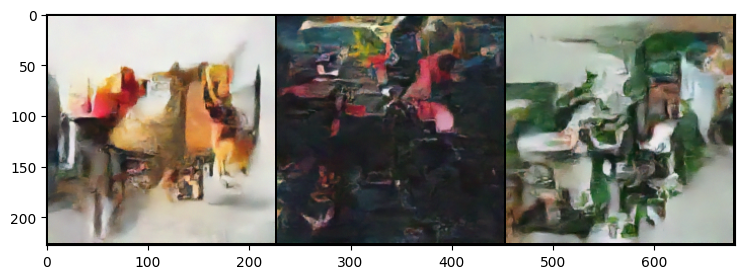

epoch 13 : loss 0.015575000084936619
['A red SUV is parked in a lot with a yellow fence in the background. The SUV has a black bumper and is positioned next to a black car. The license plate of the SUV is not visible.', 'A close-up image of a silver necklace with a large, smooth, brownish-brown stone pendant. The stone has a glossy finish and is set within a silver bezel. The necklace is displayed against a white background, and the focus is on the pendant, with the chain and clasp details not visible.', 'A panoramic view of a cityscape with a mountain in the background. The city is surrounded by trees and features a large building with a dome and a tower. The sky is clear and blue.']


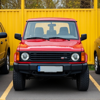

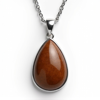

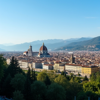

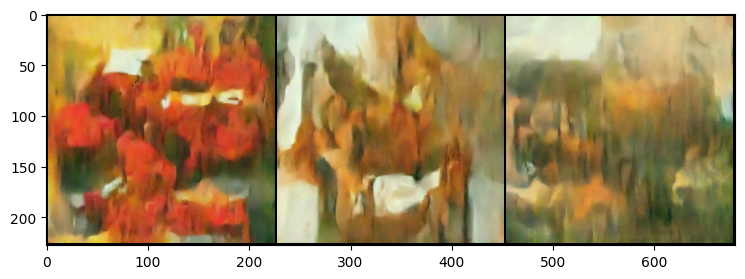

epoch 14 : loss 0.015536030754446983
["A photograph of a waterfall with a caption that reads 'Majestic by Michelle & Ryan'. The waterfall is surrounded by a forest and there is a building structure on the left side of the image. The sky is overcast with dark clouds.", 'A close-up image of two red and black camera lens caps. The caps are positioned side by side, with the red part on the left and the black part on the right. The caps have a textured surface and a metal screw at the top. The background is a plain white color.', "A signboard with the words 'Holmes County Trail' is displayed. Below the main text, there are two smaller signs with rules and regulations for the trail. The first sign reads 'Rules' and lists 'No Motorized Vehicles', 'No Hunting', 'No Dogs', 'No Firearms', 'No Motorized Bikes', 'No Motorized Scooters', 'No Motorized Vehicles', 'No Motorized Bikes', 'No Motorized Scooters', 'No Motorized Vehicles', 'No Motorized Bikes', 'No Motorized Scooters', 'No Motorized Vehic

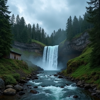

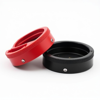

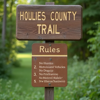

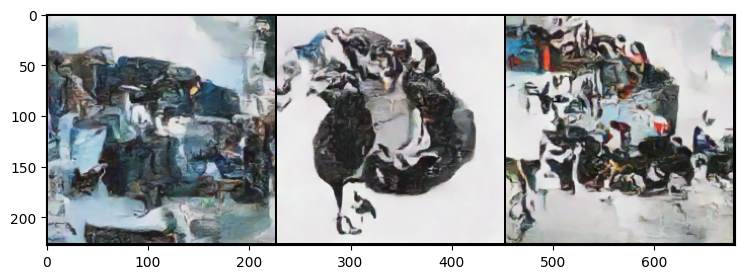

In [48]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()
        x = batch['pixel_values']
        text_emb = batch['text_emb'].to(dtype)
        text_attn_mask = batch['text_attn_mask']
        x_noisy, noise, random_timesteps = add_noise(x, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model(
            x=x_noisy.to(dtype),
            t=random_timesteps,
            c=text_emb,
            c_mask=text_attn_mask,
        )  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    random_selected_data = hf_dataset.shuffle().select(range(3))[:]
    texts = [d['prompt'] for d in random_selected_data['json']]
    print(texts)
    display(random_selected_data['jpg'][0].resize((100, 100)))
    display(random_selected_data['jpg'][1].resize((100, 100)))
    display(random_selected_data['jpg'][2].resize((100, 100)))
    gen_img = generate(model, texts=texts)
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.float().permute(1, 2, 0))
    plt.show()

    torch.save(model.state_dict(), f'./denoise_model_tmp.pt')

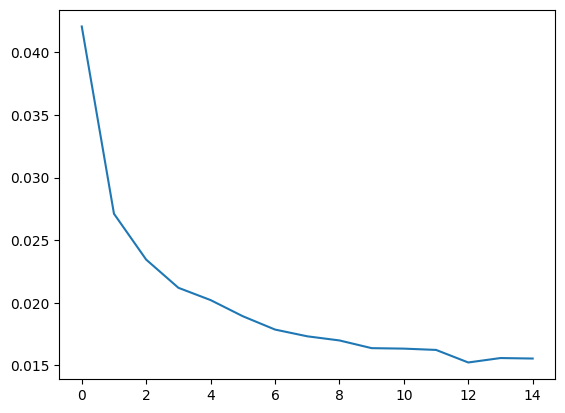

In [49]:
plt.plot(loss_history)

## 7. Generate Images with Trained Model

In [51]:
%%time
random_selected_data = hf_dataset.shuffle().select(range(4*4))[:]
gen_img = generate(model, texts=[d['prompt'] for d in random_selected_data['json']])

CPU times: user 1min 41s, sys: 767 ms, total: 1min 41s
Wall time: 1min 41s


In [52]:
gt_images = torch.stack([image_transforms(img) for img in random_selected_data['jpg']], dim=0)

In [53]:
gen_img = 0.5 * gen_img + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11755937..1.1507505].


['A woman wearing a grey beanie and a blue scarf with a patterned design stands by the ocean.', 'A police officer is standing beside a police car on a wet road in front of a school building. There are other cars parked on the side of the road, and a bus is visible in the background. The sky is overcast, and there is snow on the ground and on the cars.', "A close-up view of a pet emergency card with a paw print design. The card has a red background with white text that reads 'IN CASE OF EMERGENCY ABOUT OUR PETS'. Below the text, there is a section for 'PET NAME', 'CONTACT', and 'EMERGENCY CONTACT'. The card is placed on a patterned rug with a floral design.", 'A pair of white New Balance sneakers with black accents is displayed against a white background. The sneakers have white laces, a white toe cap, and a black heel counter. The midsole is white with black accents, and the outsole is a combination of white and black. The sneakers are placed on a surface that appears to be a white tab

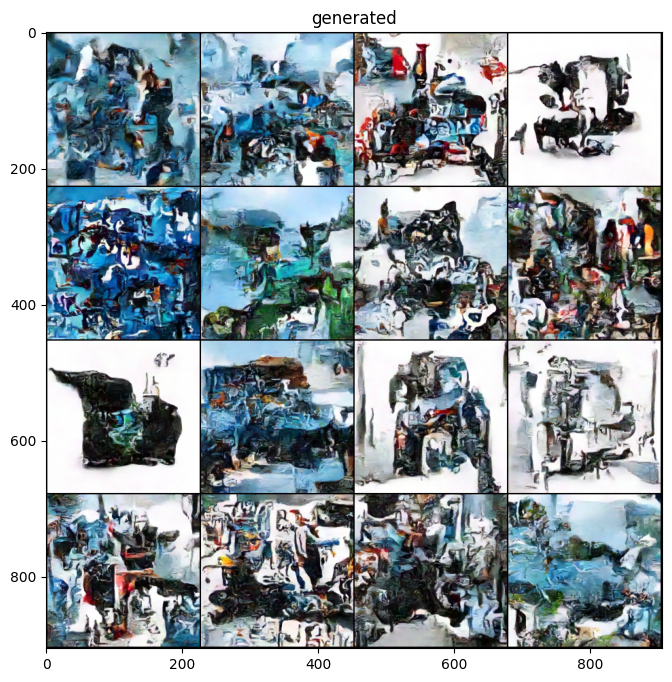

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


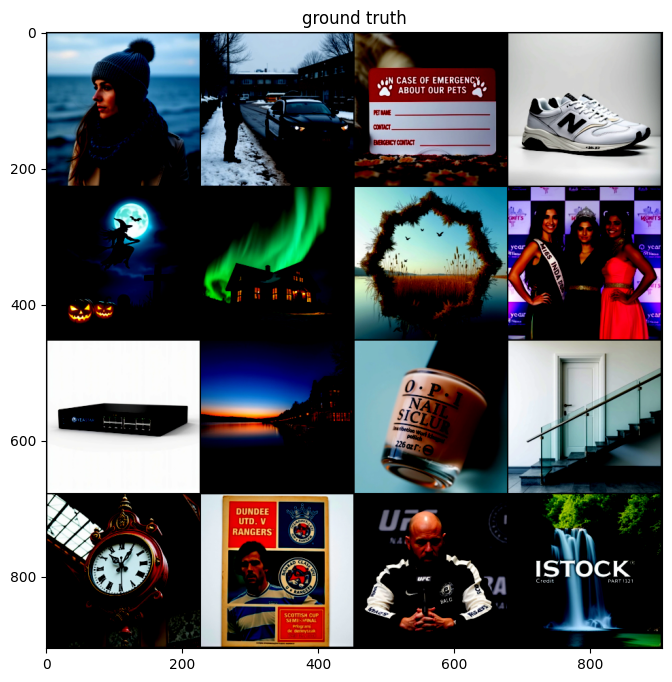

In [56]:
print([d['prompt'] for d in random_selected_data['json']])

grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))
plt.title('generated')
plt.show()

grid_gt_image = torchvision.utils.make_grid(gt_images.cpu(), nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_gt_image.permute(1, 2, 0))
plt.title('ground truth')
plt.show()